# ExploringTemporalData
**Eli Simic Robertson**

In [19]:
import pandas as pd
import numpy as np
from pprint import pprint
import random
import networkx as nx 
import matplotlib.pyplot as plt 
import collections

# deprecation warnings
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [20]:
'''Need source for code
'''

class GraphVisualization: 
   
    def __init__(self): 
          
        # visual is a list which stores all  
        # the set of edges that constitutes a 
        # graph 
        self.visual = [] 
          
    # addEdge function inputs the vertices of an 
    # edge and appends it to the visual list 
    def addEdge(self, a, b): 
        temp = [a, b] 
        self.visual.append(temp) 
          
    # In visualize function G is an object of 
    # class Graph given by networkx G.add_edges_from(visual) 
    # creates a graph with a given list 
    # nx.draw_networkx(G) - plots the graph 
    # plt.show() - displays the graph 
    def visualize(self): 
        G = nx.Graph() 
        G.add_edges_from(self.visual) 
        nx.draw_networkx(G) 
        plt.show() 
  

## Generating My Own Data

In [21]:
body_constr = [0,20]
head_constr = [0,10]

# BODY_CONST = 'body'
HEAD_CONST = 'head'
ROOT_CONST = 'root'
A = 'a'
always = 100

In [25]:
def time_interval(body_constr): return tuple(np.random.uniform(body_constr)) 

def unique_body_symbols(low=3, high=5, single=False):
    '''Creates a random unique list of symbols for the body 
    of pattern. Symbol A has been excluded from the list as it is reserved 
    for the head of the pattern.
        Args: 
            n_body_symbols (int): amount of body symbols
            
        Returns:
            random_symbols (list): random choice of symbols
    '''
    symbols = ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k'] # possible body symbols
    n_bod_symbols = np.random.randint(low, high)
    if single:  n_bod_symbols = 1 
    rand_symbols = random.sample(symbols, k=n_bod_symbols)
    
    return rand_symbols

def make_edges(Edge, body_symbols, condition=None, connected_nodes=None):
    '''Args:
            Edge (named_tuple): Edge object with default fields.
            body_symbols (list): unique body symbols.
            condition (str/logical???): Conditional operator, if any.
            connected_nodes (list): list of currently connected nodes to 
            graph object.
        Returns:
            edges (list of named_tuples): 
            connected_nodes (list): 
            
    '''
    
    if condition == 'conjunction' or condition == 'disjunction':
        n_body_symbols = 2
        ## randomly choose to prepend 
    elif condition == 'negation' or condition == 'cycle':
        n_body_symbols = 1
    elif condition == None:
        n_body_symbols = len(body_symbols)
    
    edges = []
    if connected_nodes is None: connected_nodes = []
        
    
    '''
    LIMITATION DISJ/CONJ: always connect to root, do we need to sometimes prepend to a differenct connected node??? 
    Pseudo code:
    If a dis/conjunction randomly choose the popped conjunction nodes to either
    prepend to root node or existing connected nodes
    currently the condition=disjunction initially appends and then attaches with
    left over nodes. 
    
    I want to randomly choose to prepend the conj to root or
    prepend conj to an existing node.
    
    
    Make all edges except for conjunction -> root node
    or conjunction -> b node
    
    conj end_s's either root 
    
    '''
    
    for _ in range(n_body_symbols):
        sym = body_symbols.pop()
        start_t, end_t = time_interval(body_constr)
        rand_end_s = np.random.choice(connected_nodes + [ROOT_CONST])        

        if condition == 'disjunction':
            edges.append(Edge(sym, ROOT_CONST, start_t, end_t, prob=always, disjunction=True))
            connected_nodes.append(sym)
        elif condition == 'conjunction':
            edges.append(Edge(sym, ROOT_CONST, start_t, end_t, prob=always, conjunction=True))
            connected_nodes.append(sym)
        elif condition == 'negation':
            edges.append(Edge(sym, rand_end_s, start_t, end_t, prob=always, negation=True))
            connected_nodes.append(sym)
        elif condition == 'cycle':
            edges.append(Edge(sym, rand_end_s, start_t, end_t, prob=always, cycle=True))
            connected_nodes.append(sym)
        # no conditional operator, append edge to connected nodes or root
        elif condition == None:
            edges.append(Edge(sym, rand_end_s, start_t, end_t, prob=always))
            connected_nodes.append(sym)

    return edges, connected_nodes

def body_pattern(low_body=4, high_body=6, low_prob=60, high_prob=90, disjunction=False,
                   negation=False, conjunction=False, prob=always, cycle=False):
    
    body_symbols = unique_body_symbols(low_body, high_body)
    rand_num = np.random.uniform(low=0, high=always)
    prob = np.random.uniform(low=low_prob, high=high_prob)
    connected_nodes = [] # keep track of connected nodes for end_symbol possibilities
    
    pattern = [] # pattern list of edges : graph like object
    fields = ('start_s', 'end_s', 'start_t', 'end_t', 'disjunction', 'negation', 'conjunction', 'cycle', 'prob')
    Edge = collections.namedtuple('Edge', fields)
    Edge.__new__.__defaults__ = (False,) * len(Edge._fields) # set default fields

        
    if disjunction:
        edges, nodes = make_edges(Edge, body_symbols, condition='disjunction') 
        pattern.extend(edges)
        connected_nodes.extend(nodes)
        pattern.append(Edge(nodes[0], nodes[1], # disjunction edge
                    start_t=None, end_t=None, disjunction=True, prob=always))
        
    elif negation:
        edges, nodes = make_edges(Edge, body_symbols, condition='negation',
                                 connected_nodes=connected_nodes)
        pattern.extend(edges)
        connected_nodes.extend(nodes) 
        
    elif cycle:
        edges, nodes = make_edges(Edge, body_symbols, condition='cycle',
                                 connected_nodes=connected_nodes)
        pattern.extend(edges)
        connected_nodes.extend(nodes)
        
    elif conjunction:
        edges, nodes = make_edges(Edge, body_symbols, condition='conjunction')
        pattern.extend(edges)
        connected_nodes.extend(nodes)
    # remaining nodes are added to either root or connected body node
    edges, nodes = make_edges(Edge, body_symbols, condition=None,
                             connected_nodes=connected_nodes)
    pattern.extend(edges)
    connected_nodes.extend(nodes)

    return pattern

def plot_pattern(pattern):
    G = GraphVisualization() 
    for p in pattern: G.addEdge(p.start_s, p.end_s)
    G.visualize()

## Visualisations of Reference Patterns (disregarding time dimension).

### Example of Disjunction
##### Notice how connected nodes now can connect to existing disjunction

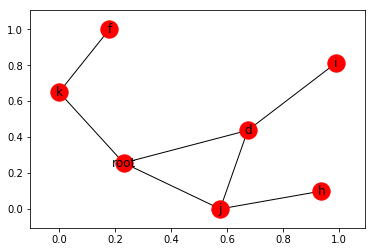

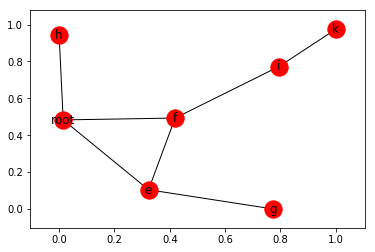

In [23]:
for _ in range(2): 
    ref_pattern = body_pattern(low_body=6, high_body=8, disjunction=True)
#     pprint(ref_pattern)
    plot_pattern(ref_pattern)

### Example of Negation

[Edge(start_s='h', end_s='root', start_t=0.5716895236656665, end_t=11.813031180097994, disjunction=False, negation=True, conjunction=False, cycle=False, prob=100), Edge(start_s='d', end_s='h', start_t=0.7632573874430583, end_t=16.25264718945497, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100), Edge(start_s='f', end_s='h', start_t=0.762139622030971, end_t=12.965157838426983, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100)]


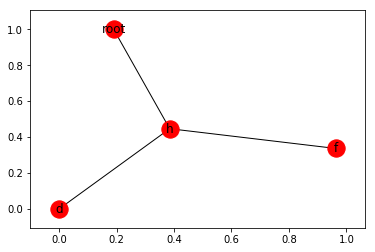

[Edge(start_s='d', end_s='root', start_t=0.05640034662285731, end_t=16.726731975248804, disjunction=False, negation=True, conjunction=False, cycle=False, prob=100), Edge(start_s='k', end_s='d', start_t=0.7690714374896765, end_t=17.71607566356528, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100), Edge(start_s='i', end_s='d', start_t=0.8560899349794481, end_t=7.242144669929804, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100)]


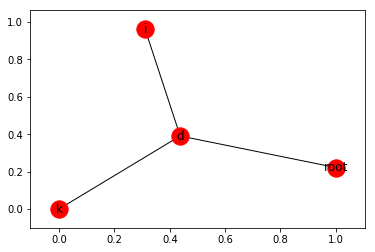

[Edge(start_s='d', end_s='root', start_t=0.05640034662285731, end_t=16.726731975248804, disjunction=False, negation=True, conjunction=False, cycle=False, prob=100),
 Edge(start_s='k', end_s='d', start_t=0.7690714374896765, end_t=17.71607566356528, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100),
 Edge(start_s='i', end_s='d', start_t=0.8560899349794481, end_t=7.242144669929804, disjunction=False, negation=False, conjunction=False, cycle=False, prob=100)]

In [27]:
for _ in range(2): 
    ref_pattern = body_pattern(low_body=3, high_body=5, negation=True)
    print(ref_pattern)
    plot_pattern(ref_pattern)

ref_pattern

### Example of Conjunction

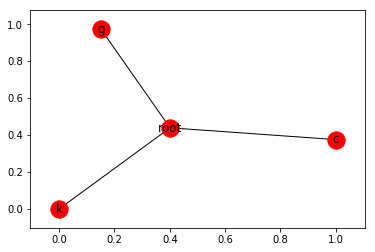

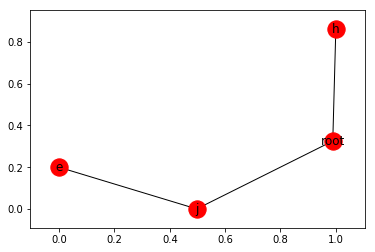

In [28]:
# Raised the low threshold to be able to perform both operators.
for _ in range(2): 
    ref_pattern = body_pattern(low_body=3, high_body=6, conjunction=True, prob=None)
    plot_pattern(ref_pattern)

## Generating Training Set
<br>

In [29]:
def time_point(start_t, end_t): return np.random.uniform(start_t, end_t)

def create_instance(patt, time_high=100000, make_pred=False): 
    '''
    Returns:
        ts (list): list of lists of time point and symbol adhereing
        to pattern definition'''
    
    ts = [] # empty time series list
    pred = []

    root_tp = time_point(start_t=0, end_t=time_high)
    head_prob = np.random.uniform(low=60, high=90)
    
    if make_pred: # if pattern instance create pred for .pred file
        start_t, end_t = time_interval(head_constr)    
        head_tp = root_tp + time_point(start_t, end_t)
        pred.append([head_tp, A])
    
        if np.random.uniform(low=0, high=100) > head_prob: # whether pattern has consequent 
            ts.append([head_tp, A])

    rand_num = np.random.uniform(low=0, high=100)

    disjs = []
    for edge in patt:
        if edge.start_t is None: # mutual exclusion edge case
            continue

        elif edge.disjunction == True and make_pred == True:
            disjs.append(edge)

        elif edge.conjunction: # already done, as all edges 
            pass 

        elif edge.cycle: # Unsure if 
            cycle_iters = np.random.randint(low=1, high=3)
            for cyc in range(cycle_iters):
                ts.append([root_tp - time_point(edge.start_t, edge.end_t), edge.start_s])

            ## INSERT LOGIC: repeat subset or entire pattern, need for mutual exclusion 
            # if just setting threshold , e.g cycle_iters above???

        elif edge.negation: # skip negation node
            continue

        else:# for non-conditional edges  
            ts.append([root_tp - time_point(edge.start_t, edge.end_t), edge.start_s])

    if len(disjs) > 1: # if there are multiple disjunctions, randomly choose one for .event
        disj = disjs[np.random.randint(low=0, high=len(disjs) - 1)] 
        ts.append([root_tp - time_point(disj.start_t, disj.end_t), disj.start_s])
    
    # create root in ts if it isn't empty pattern (edge case when subset retrurns empty subset, e.g [])
    if patt == []: 
        return ts
    elif make_pred:
        ts.append([root_tp, ROOT_CONST])
        return ts, pred
    else:
        return ts # when a random subset, return only ts


## Making Noise!

**Time Series Consists of: **<br>
- Singular Pattern replicated over time line
- Random Subsets of the Pattern (func: rand_subset)
- Individual Noisy Symbols

In [30]:
def rand_subset(pattern, time_high=100000): # random subset of the instance
    '''
    Returns:
        ts (list): list of lists of time point and symbol of
        random subset of the pattern definition'''
    subset_idxs = sorted([np.random.randint(low=0, high=len(pattern)) for _ in range(2)])
    sub_pattern = pattern[subset_idxs[0]: subset_idxs[1]]
    
    return sub_pattern
    
def noisy_instance(time_high=100000):
    ''' Input: 
            time_high (int): 
    
            Returns:
                ts (list): list of lists containing random time point and symbol'''
    
    sym = unique_body_symbols(single=True).pop()
    tp = time_point(start_t=0, end_t=time_high)
    inst = [[tp, sym]]
    return inst

def create_train(n_patterns, n_subsets, n_noisy_insts,
                 low_body=4, high_body=6, low_prob=60, high_prob=90,
                 disjunction=False, negation=False, conjunction=False, 
                 prob=100, cycle=False):
    '''Returns:
            events (list): time series for training/testing set
            preds (list): ground truth values
    '''
    patt = body_pattern(low_body=4, high_body=6, low_prob=60, high_prob=90,
                 disjunction=False, negation=False, conjunction=False, prob=100, cycle=False)
    
    events, preds = [], []
    
    for _ in range(n_patterns):
        event, pred =  create_instance(patt, make_pred=True)
        events.extend(event)
        preds.extend(pred)
        
    for _ in range(n_subsets):
        event = create_instance(rand_subset(patt))
        if event != []:
            events.extend(event)
        else:
            continue
        
    for _ in range(n_noisy_insts):
        event = noisy_instance()
        events.extend(event)
    
    events.sort(key=lambda x: x[0])
    preds.sort(key=lambda x: x[0])# sort by timestamp
    
    return events, preds
    


## Output to file.

In [31]:
events, preds = create_train(n_patterns=100, n_subsets=500, n_noisy_insts=500)

In [32]:
events[:5]

[[108.49224912612368, 'g'],
 [112.37593071014393, 'd'],
 [113.54302127289397, 'h'],
 [142.3393537819538, 'h'],
 [143.48021450134553, 'd']]

In [33]:
preds[:5]

[[508.94898762425896, 'a'],
 [983.2076800933537, 'a'],
 [2373.5939926280907, 'a'],
 [2633.3125999976637, 'a'],
 [3040.087125638511, 'a']]

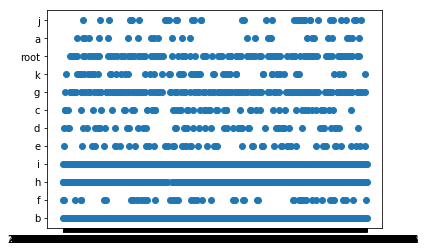

In [13]:
X = np.array(events)

values = list(X[:, 1])
names = list(X[:, 0])

plt.scatter(names, values);
plt.show()

In [34]:
with open('n_patterns_100_n_subsets_500_n_noisy_insts_500.event', 'w') as file:
    for l in events:
        s = str(l[0]) + ' ,' + str(l[1]) + '\n'
        file.write(s)

## LMK what you think :)

**Concerns:**<br>
disjunction and conjunction always connect to root node fist, do we need to have a pattern where a random